In [10]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from celluloid import Camera
from matplotlib.backend_bases import FigureCanvasBase
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import timeit

from src.environment_old import LogEnv_old
from src.utils import path_distance_new
from src.vizualisation import demonstration, action_animation
from src.evaluation import compute_mean_metric, compute_data_metric, compute_mean_metric_with_or
from src.or_functions import compute_distance

#from src.environment import LogEnv
#from src.train import train
#from src.architecture import AttentionModel
from src.environment_jampr import LogEnv
from src.architecture_jampr import AttentionModel
from src.train_jampr import train

In [ ]:
opts = {#'metric': 1.5
        'demand_type': {'distribution': 'uniform', 'max_demand':10},
        #'tw_type': {'distribution': 'uniform'},
        #"pickup_and_delivery":True
        'depot':{'distribution':'random'}
       }

In [18]:
model = AttentionModel().to("cuda")

In [19]:
%%time
train(model,'cuda', epochs=1, T=1000, lr=1e-4, batch_size=128, problem_size=20)











  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [35]:
2646/21

126.0

## Анимация

In [ ]:
opts = {'demand_type': {'distribution': 'uniform', 'max_demand':10},
        #'tw_type': {'distribution': 'uniform'},
        #"pickup_and_delivery":True
       }

n = 10
batch_size = 1
env = LogEnv(batch_size=batch_size, n=n, opts=opts)

features, distances, mask = env.reset()

demonstration(env, opts)

In [ ]:
actions_ext = np.array([2, 7, 3, 5, 1, 0, 6, 8, 9, 4])
action_animation(env, opts, actions_ext, '1-OtOPDTW.gif', 500)

## Проверка модели CVRP, обученной на сервере

In [ ]:
# DTSP_20_Dec_20_21_14_09_2020.pkl
#
# TWTSP_20_Dec_24_05_51_22_2020.pkl
# 
# PDTSP_20_Dec_23_07_07_17_2020.pkl
#

In [8]:
file_name = 'TWTSP_20_Dec_24_05_51_22_2020'

In [9]:
f = open('./models/' + file_name + '.pkl', 'rb')
weights = pickle.load(f)
f.close()

In [10]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [11]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

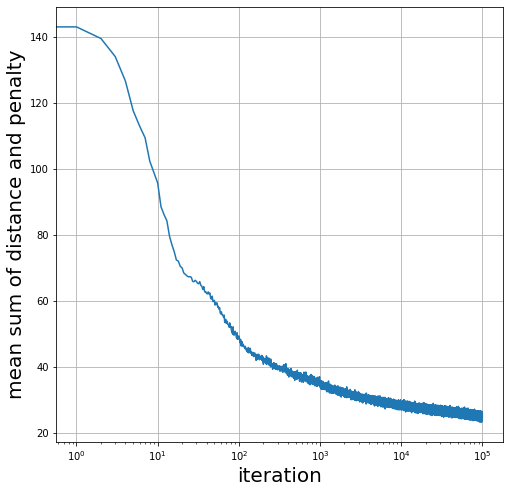

In [26]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
fig.savefig('reward_20_twtsp.png')

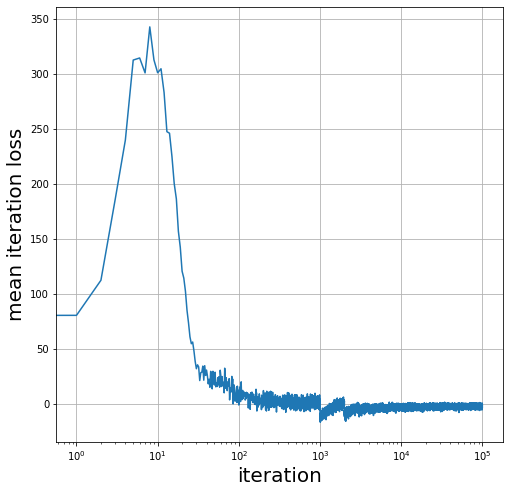

In [27]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
fig.savefig('loss_20_twtsp.png')

In [28]:
model = AttentionModel().to("cuda")
model.load_state_dict(weights)

<All keys matched successfully>

In [29]:
model.eval()
print('r')

r


In [30]:
opts = {#'metric': 1.5
        #'demand_type': {'distribution': 'uniform', 'max_demand':10},
        'tw_type': {'distribution': 'uniform', 'service_time': 0},
        #"pickup_and_delivery":True
        'depot':{'distribution':'random'}
       }

In [ ]:
%%time
compute_mean_metric_with_or(model, device="cuda", n=20, batch_size=2, T=1, options=opts, sample=False, time_limit=0.06)

In [ ]:
compute_mean_metric(model, device="cuda", n=20, batch_size=250, T=40, opts=opts, sample=False)

In [31]:
device = 'cuda'

In [ ]:
env = LogEnv(n=10, batch_size=2, opts=opts)

features, distances, mask, context = env.reset()
features = torch.Tensor(features).to(device)
context = torch.Tensor(context).to(device)

print(features[:, :, 2])
#print(features[:, :, 3:5])
#print(env._pairs)
mask = env.init_mask()
context = env.set_context()

flag_done = False
t = 0

while not flag_done:
    print(mask)
    v1 = int(input())
    v2 = int(input())
    v = torch.tensor([v1, v2], dtype=torch.int64)
    v = v.reshape(2,-1)
    with torch.no_grad():
        mask, flag_done, context = env.step(v)
        context = torch.Tensor(context).to(device)
    t += 1

route = torch.tensor(env._cur_route, dtype=int)

In [32]:
env._cur_route

NameError: name 'env' is not defined

In [33]:
path_distance_new(env._distances, env._cur_route)

NameError: name 'env' is not defined

In [34]:
env = LogEnv_old(n=20, batch_size=1, opts=opts)

features, distances, mask, context = env.reset()
features = torch.Tensor(features).to(device)
context = torch.Tensor(context).to(device)
flag_done = False
t = 0

while not flag_done:
    v, _ = model(features, mask, t, context, flags=env._flags)
    v = v.to('cpu')
    with torch.no_grad():
        mask, flag_done, context = env.step(v)
        context = torch.Tensor(context).to(device)
    t += 1

route = torch.tensor(env._cur_route, dtype=int)

In [35]:
actions_ext = route.squeeze().tolist()

In [36]:
actions_ext

[6, 16, 12, 18, 0, 13, 9, 19, 8, 15, 10, 11, 3, 1, 7, 2, 5, 4, 17, 14]

current time: 0.98
not attended vertexes: None


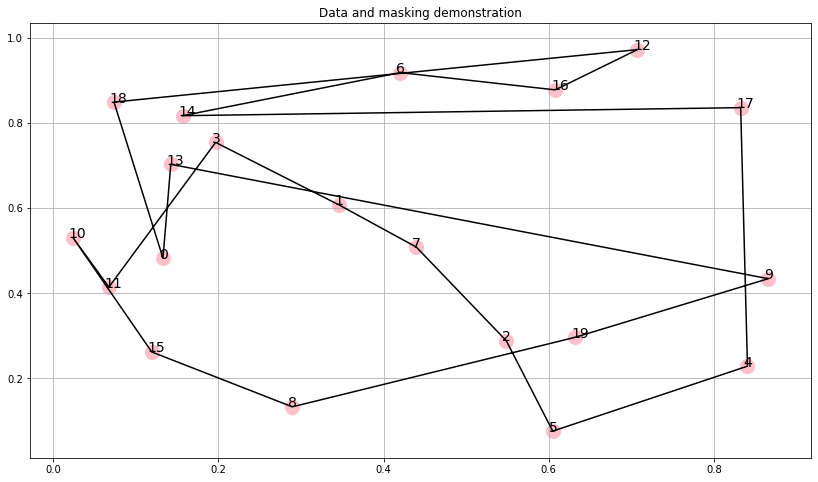

In [37]:
demonstration(env, opts, actions_ext=None)

In [ ]:
action_animation(env, opts, actions_ext, '1-OtOPDTW.gif', 500)

In [ ]:
route

## Проверка TSP random по сравнению с TSP 20 и TSP 50

## Проверка TSP 20 и TSP 50 на реальных данных

### TSP 50

In [ ]:
f = open('./data/parsed_data/dataset_50.pkl', 'rb')

dataset_50 = pickle.load(f)

f.close()

f = open('./data/parsed_data/dataset_dist_50.pkl', 'rb')

dataset_dist_50 = pickle.load(f)

f.close()

dist = list(map(lambda x: x[:, :, 0].reshape(-1, 50, 50), dataset_dist_50))
data = list(map(lambda x: {'dots': x.reshape(-1, 50, 2)}, dataset_50))

In [ ]:
%%time
or_res = []
avg_time = 6.9/len(data)
for i in range(len(dist)):
    or_res.append(compute_distance(dist[i].reshape(50, 50), eps=1e-2, time_limit=avg_time))

In [ ]:
f = open('./models/TSP_50_Dec__2_03_37_08_2020.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel().to("cuda")
model.load_state_dict(weights)
model.eval()
distances = compute_data_metric(model, data, dist, device, 50, opts)

fig = plt.figure(figsize=(8,8))
plt.plot((1 - or_res/distances)*100)
plt.plot(np.arange(len(or_res)), np.ones((len(or_res)))*(1 - or_res/distances).mean()*100)
plt.grid()
plt.xlabel('problem instance', fontsize=20)
plt.ylabel('%', fontsize=20)
plt.ylim((-5, 55))
plt.plot(np.arange(len(or_res)), np.zeros((len(or_res))), 'black', linewidth=1.5)
plt.legend(['gap to OR-tools', 'mean gap'], fontsize=12)

print((1 - or_res/distances).mean())
print((1 - or_res/distances)*100)
plt.savefig('50_2.jpg')

In [ ]:
f = open('./models/TSP_50_Dec__4_18_08_05_2020_1_5.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel().to("cuda")
model.load_state_dict(weights)
model.eval()


opts = {}
device = 'cuda'

distances = compute_data_metric(model, data, dist, device, 50, opts)

fig = plt.figure(figsize=(8,8))
plt.plot((1 - or_res/distances)*100)
plt.plot(np.arange(len(or_res)), np.ones((len(or_res)))*(1 - or_res/distances).mean()*100)
plt.grid()
plt.xlabel('problem instance', fontsize=20)
plt.ylabel('%', fontsize=20)
plt.ylim((-5, 55))
plt.plot(np.arange(len(or_res)), np.zeros((len(or_res))), 'black', linewidth=1.5)
plt.legend(['gap to OR-tools', 'mean gap'], fontsize=12)

print((1 - or_res/distances).mean())
print((1 - or_res/distances)*100)
plt.savefig('50_1_5.jpg')

In [ ]:
((1 - or_res/distances)*100)[37]

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.scatter(data[37]['dots'].squeeze()[:, 0], data[37]['dots'].squeeze()[:, 1])
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.grid()
plt.savefig('50_37.jpg')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.scatter(data[49]['dots'].squeeze()[:, 0], data[49]['dots'].squeeze()[:, 1])
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.grid()
plt.savefig('50_49.jpg')

In [ ]:
f = open('./models/TSP_50_Dec_10_03_33_58_2020_1.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel().to("cuda")
model.load_state_dict(weights)
model.eval()
distances = compute_data_metric(model, data, dist, device, 50, opts)

fig = plt.figure(figsize=(8,8))
plt.plot((1 - or_res/distances)*100)
plt.plot(np.arange(len(or_res)), np.ones((len(or_res)))*(1 - or_res/distances).mean()*100)
print((1 - or_res/distances).mean())
print((1 - or_res/distances)*100)
plt.grid()
plt.xlabel('problem instance', fontsize=20)
plt.ylabel('%', fontsize=20)
plt.ylim((-5, 55))
plt.plot(np.arange(len(or_res)), np.zeros((len(or_res))), 'black', linewidth=1.5)
plt.legend(['gap to OR-tools', 'mean gap'], fontsize=12)


plt.savefig('50_1.jpg')

### TSP 20

In [ ]:
f = open('./data/parsed_data/dataset_20.pkl', 'rb')

dataset_20 = pickle.load(f)

f.close()

f = open('./data/parsed_data/dataset_dist_20.pkl', 'rb')

dataset_dist_20 = pickle.load(f)

f.close()

dist = list(map(lambda x: x[:, :, 0].reshape(-1, 20, 20), dataset_dist_20))
data = list(map(lambda x: {'dots': x.reshape(-1, 20, 2)}, dataset_20))

device = 'cuda'
opts = {}

In [ ]:
%%time
or_res = []
avg_time = 3.3/len(data)
for i in range(len(dist)):
    data_input = {}
    data_input['dist'] = dist[i].reshape(20, 20)
    or_res.append(compute_distance(data_input, eps=1e-2, time_limit=avg_time))

In [ ]:
f = open('./models/TSP_20_Dec__2_22_09_52_2020.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel().to("cuda")
model.load_state_dict(weights)
model.eval()

distances = compute_data_metric(model, data, dist, device, 20, opts)

fig = plt.figure(figsize=(8,8))
plt.plot(100*(1 - or_res/distances))
plt.plot(np.arange(len(or_res)), np.ones((len(or_res)))*(1 - or_res/distances).mean()*100, '--')
print((1 - or_res/distances).mean())
print((1 - or_res/distances)*100)
plt.grid()
plt.xlabel('problem instance', fontsize=20)
plt.ylabel('%', fontsize=20)
plt.ylim((-5, 45))
plt.plot(np.arange(len(or_res)), np.zeros((len(or_res))), 'black',linewidth=1.5)
plt.legend(['gap to OR-tools', 'mean gap'], fontsize=12)
plt.savefig('20_2.jpg')

In [ ]:
f = open('./models/TSP_20_Dec__3_05_28_40_2020_1_5.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel().to("cuda")
model.load_state_dict(weights)
model.eval()

distances = compute_data_metric(model, data, dist, device, 20, opts)

fig = plt.figure(figsize=(8,8))
plt.plot(100*(1 - or_res/distances))
plt.plot(np.arange(len(or_res)), np.ones((len(or_res)))*(1 - or_res/distances).mean()*100, '--')
print((1 - or_res/distances).mean())
print((1 - or_res/distances)*100)
plt.grid()
plt.xlabel('problem instance', fontsize=20)
plt.ylabel('%', fontsize=20)
plt.ylim((-5, 45))
plt.plot(np.arange(len(or_res)), np.zeros((len(or_res))), 'black', linewidth=1.5)
plt.legend(['gap to OR-tools', 'mean gap'], fontsize=12)
plt.savefig('20_1_5.jpg')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.scatter(data[44]['dots'].squeeze()[:, 0], data[44]['dots'].squeeze()[:, 1])
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.grid()
plt.savefig('20_44.jpg')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.scatter(data[10]['dots'].squeeze()[:, 0], data[10]['dots'].squeeze()[:, 1])
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.grid()
plt.savefig('20_10.jpg')

In [ ]:
((1 - or_res/distances)*100)[10]

In [ ]:
f = open('./models/TSP_20_Dec__9_12_16_36_2020_1.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel().to("cuda")
model.load_state_dict(weights)
model.eval()

distances = compute_data_metric(model, data, dist, device, 20, opts)

fig = plt.figure(figsize=(8,8))
plt.plot(100*(1 - or_res/distances))
plt.plot(np.arange(len(or_res)), np.ones((len(or_res)))*(1 - or_res/distances).mean()*100, '--')
print((1 - or_res/distances).mean())
print((1 - or_res/distances)*100)
plt.grid()
plt.xlabel('problem instance', fontsize=20)
plt.ylabel('%', fontsize=20)
plt.ylim((-5, 45))
plt.plot(np.arange(len(or_res)), np.zeros((len(or_res))), 'black', linewidth=1.5)
plt.legend(['gap to OR-tools', 'mean gap'], fontsize=12)
plt.savefig('20_1.jpg')

## Эксперименты с разным способом генерации данных

In [ ]:
f = open('./models/TSP_20_Dec__2_22_09_52_2020.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel().to("cuda")
model.load_state_dict(weights)
model.eval()
print('r')



In [ ]:
%%time

opts = {}
device = 'cuda'

model_metric, or_metric = compute_mean_metric_with_or(model, device="cuda", n=20, batch_size=250, T=10, opts=opts, sample=False, time_limit=0.2)
print(model_metric)
print(or_metric)

In [ ]:
opts = {'graph_type': {'distribution':'normal_capped', 'sigma': 'default', 'cov': 'default'}}
device = 'cuda'

model_metric, or_metric = compute_mean_metric_with_or(model, device="cuda", n=20, batch_size=250, T=10, opts=opts, sample=False, time_limit=0.2)
print(model_metric)
print(or_metric)

In [ ]:
%%time
opts = {'graph_type': {'distribution':'centroids', 'num_cent':'poisson', 'lambda': 'default'}}
device = 'cuda'

model_metric, or_metric = compute_mean_metric_with_or(model, device="cuda", n=20, batch_size=250, T=10, opts=opts, sample=False, time_limit=0.2)
print(model_metric)
print(or_metric)

In [ ]:
f = open('./models/TSP_50_Dec__2_03_37_08_2020.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel().to("cuda")
model.load_state_dict(weights)
model.eval()
print('r')

In [ ]:
%%time
opts = {}
device = 'cuda'

model_metric, or_metric = compute_mean_metric_with_or(model, device="cuda", n=50, batch_size=250, T=10, opts=opts, sample=False, time_limit=0.2)
print(model_metric)
print(or_metric)

In [ ]:
%%time
opts = {'graph_type': {'distribution':'normal_capped', 'sigma': 'default', 'cov': 'default'}}
device = 'cuda'

model_metric, or_metric = compute_mean_metric_with_or(model, device="cuda", n=50, batch_size=250, T=10, opts=opts, sample=False, time_limit=0.2)
print(model_metric)
print(or_metric)

In [ ]:
%%time
opts = {'graph_type': {'distribution':'centroids', 'num_cent':'poisson', 'lambda': 'default'}}
device = 'cuda'

model_metric, or_metric = compute_mean_metric_with_or(model, device="cuda", n=50, batch_size=250, T=10, opts=opts, sample=False, time_limit=0.2)
print(model_metric)
print(or_metric)

## Эксперименты с обученной моделью для различных размерностей

In [ ]:
f = open('./models/TSP_random_Dec__9_08_40_44_2020.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel().to("cuda")
model.load_state_dict(weights)
model.eval()
print('r')

In [ ]:
n_array = np.array([20, 30, 40, 50, 60, 70, 80]) 

opts = {}
device = 'cuda'

In [ ]:
m_list = []
or_list = []
for n in n_array:
    a, b = compute_mean_metric_with_or(model, device="cuda", n=n, batch_size=250, T=10, opts=opts, sample=False, time_limit=0.2)
    m_list.append(a)
    or_list.append(b)

m_array = np.array(m_list)
or_array = np.array(or_list)

print(m_array)
print(or_array)

In [ ]:
f = open('./models/TSP_20_Dec__2_22_09_52_2020.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel().to("cuda")
model.load_state_dict(weights)
model.eval()
print('r')

In [ ]:
%%time
m_list = []
or_list = []
for n in n_array:
    print(n)
    a, b = compute_mean_metric_with_or(model, device="cuda", n=n, batch_size=250, T=10, opts=opts, sample=False, time_limit=0.2)
    m_list.append(a)
    or_list.append(b)

m_array = np.array(m_list)
or_array = np.array(or_list)

print(m_array)
print(or_array)

In [ ]:
f = open('./models/TSP_50_Dec__2_03_37_08_2020.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel().to("cuda")
model.load_state_dict(weights)
model.eval()
print('r')

In [ ]:
%%time
m_list = []
or_list = []
for n in n_array:
    print(n)
    a, b = compute_mean_metric_with_or(model, device="cuda", n=n, batch_size=250, T=10, opts=opts, sample=False, time_limit=0.2)
    m_list.append(a)
    or_list.append(b)

m_array = np.array(m_list)
or_array = np.array(or_list)

print(m_array)
print(or_array)

In [ ]:
model_r = np.array([3.87050629,4.62435837,5.27152544,5.81636443,6.33917975,6.83483149,7.31087901])
model_20 = np.array([3.84305319,4.60641323,5.28611594,5.93525022,6.56958162,7.19202682,7.80516384])
model_50 = np.array([3.87700804,4.63563028,5.25374926,5.81009937,6.35052951,6.8391449, 7.31601485])
or_tools_r = np.array([3.8343843,4.59459426,5.26263097,5.81793746,6.34257443,6.81399806,7.27161865])
or_tools_20 = np.array([3.83344753,4.59501778,5.25193204,5.82680912,6.33722093,6.81935426,7.26293028])
ot_tools_50 = np.array([3.83328594,4.59883794,5.24471187,5.81640416,6.3336697,6.8100551, 7.26375723])

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.plot(n_array, 100*(1-or_tools_r/model_r))
plt.plot(n_array, 100*(1-or_tools_20/model_20))
plt.plot(n_array, 100*(1-ot_tools_50/model_50))
plt.grid()
plt.legend(['random TSP', 'TSP 20', 'TSP 50'])
plt.xlabel('problem size', fontsize=20)
plt.ylabel('%', fontsize=20)
plt.savefig('n_test.jpg')

In [ ]:
x = [1, 2]
y_1 = [0.267240368, 0.095023832]
y_2 = [0.522693949, 1.520975557]
y_3 = [2.275521879, 19.70259851]

In [ ]:
plt.bar(x, y_1)
plt.bar(x, y_2)
plt.bar(x, y_3)